Задача
1. Сравните результат между тестом и контролем по двум кейсам:

Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.
2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

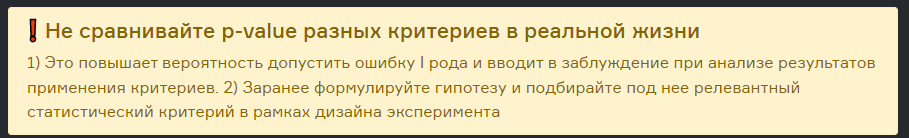

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

Загружаем и подготавливаем данные

In [2]:
df = pd.read_csv("https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv", decimal =',', sep=';')


In [3]:
control = df.query('experimentVariant == "Control"').value.tolist()
test    = df.query('experimentVariant == "Treatment"').value.tolist()
df = pd.DataFrame({"control": control, "test": test})


Применяем критерий Манна — Уитни

In [4]:
mannwhitneyu(control, test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Критерий Манна — Уитни не показал статистически значимых различий между выборками

Применяем бутстрап с параметрами статистики np.mean и np.median, смотрим на p-value.

In [5]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) #mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

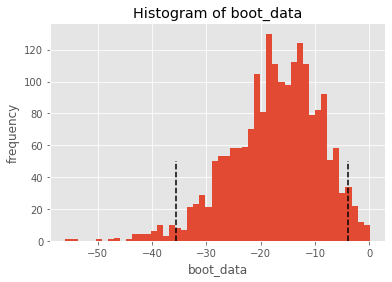

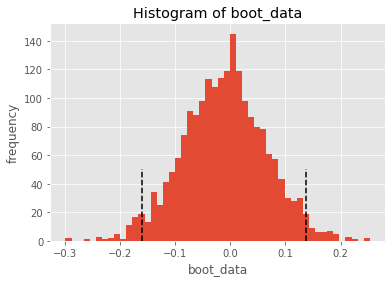

In [6]:
booted_data_mean = get_bootstrap(df.control, df.test, boot_it = 2000)
booted_data_median = get_bootstrap(df.control, df.test, boot_it = 2000,statistic = np.median)

In [7]:
booted_data_mean["p_value"]

0.03535208201797656

In [8]:
booted_data_median["p_value"]

0.8887665411569883

p-value средних показал статистически значимые различия (<0.05), в то время как p-value медианых такого различия не показал. 

В чем причина такого поведения? Попробуем посмотреть на распределеня наших основных выборок:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34d9508588>,
      dtype=object)

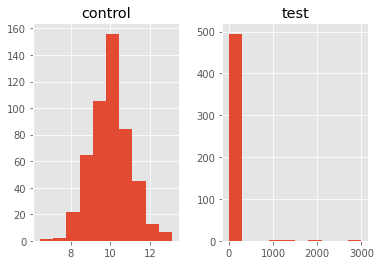

In [9]:
df.hist()

Как видно на графиках, в контрольной группе распределение значений похоже на нормальное, в то время как в тестовой группе имеются значительные выбросы.

На основе полученных результатво эксперимента можно сделать вывод о том, что применение бутстрап метода со статистикой по средним сильно подвержено выбросам и может давать ложные показания.

Для наглядности попробуем повторить эксперимент, исключив из тестовой группы выбросы:

In [10]:
df1 = df.query('test < 100')

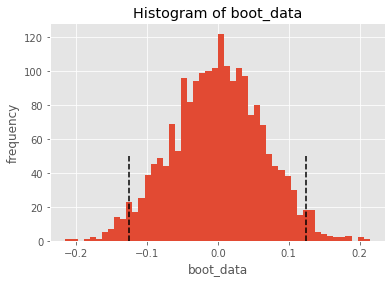

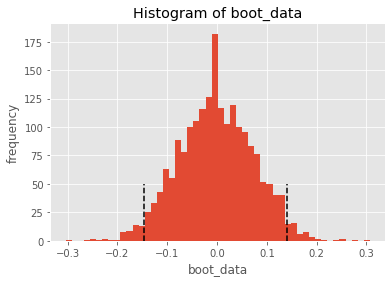

In [11]:
booted_data_mean = get_bootstrap(df1.control, df1.test, boot_it = 2000)
booted_data_median = get_bootstrap(df1.control, df1.test, boot_it = 2000,statistic = np.median)

In [12]:
booted_data_mean["p_value"]

0.995436020895437

In [13]:
booted_data_median["p_value"]

0.9827417961154782

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34d9204160>,
      dtype=object)

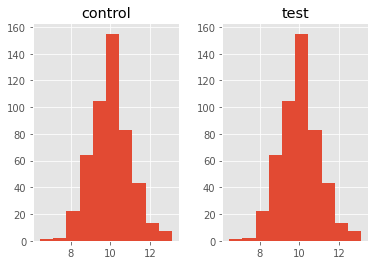

In [14]:
df1.hist()

Как мы видим, при отсутствии выбросов тесты дают практически одинаковые результаты.


Что не удивительно, поскольку данные отличались только наличием выбросов в контрольной группе:

In [15]:
df1.sum()

control    4960.749528
test       4960.749528
dtype: float64

# Ответ преподавателя


Верно следующее утверждение: Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки (иногда путают с равенством медиан, но на самом деле проверяется не только медиана). Также вы верно применили критерии и написали код


Про разное количество наблюдений в выборках: Манн-Уитни как и любой статистический оценщик не очень приветлив к дисбалансу. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект). Подробнее тут https://stats.stackexchange.com/questions/40342/mann-whitney-u-test-with-unequal-sample-sizes

## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы

## Оценка 10/10

Хорошего дня!